In [160]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from catboost import CatBoostRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from darts.utils.statistics import check_seasonality, plot_acf

from sklearn.linear_model import LinearRegression

from scipy.stats import t
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.metrics import mean_absolute_error

sns.set(rc={'figure.figsize':(14.7,10)})

## Load data and EDA

In [154]:
df = pd.read_csv('ВС DS Сбер data.csv', delimiter=';')

In [155]:
df.REPORTDATE = pd.to_datetime(df.REPORTDATE, infer_datetime_format=True)

In [156]:
df.set_index('REPORTDATE', inplace=True)

In [157]:
df.head()

,VALUE
REPORTDATE,
2013-12-30,3457625638
2013-12-31,3417092149
2014-01-01,3417092149
2014-01-02,3417092149
2014-01-03,3417092149


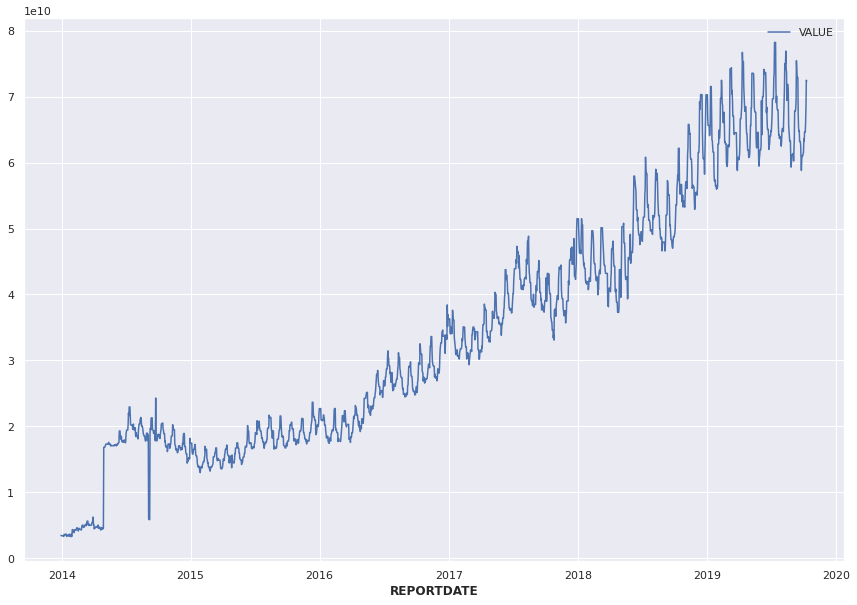

In [6]:
sns.lineplot(data=df);

In [7]:
def decompose_df(df, share_type='VALUE', samples=250, period=30):
    if samples == 'all':
        #decomposing all time series timestamps
        res = seasonal_decompose(df[share_type].values, period=period)
    else:
        #decomposing a sample of the time series
        res = seasonal_decompose(df[share_type].values[-samples:], period=period)
    
    observed = res.observed
    trend = res.trend
    seasonal = res.seasonal
    residual = res.resid
    
    #plot the complete time series
    fig, axs = plt.subplots(4, figsize=(16,8))
    axs[0].set_title('OBSERVED', fontsize=16)
    axs[0].plot(observed)
    axs[0].grid()
    
    #plot the trend of the time series
    axs[1].set_title('TREND', fontsize=16)
    axs[1].plot(trend)
    axs[1].grid()
    
    #plot the seasonality of the time series. Period=24 daily seasonality | Period=24*7 weekly seasonality.
    axs[2].set_title('SEASONALITY', fontsize=16)
    axs[2].plot(seasonal)
    axs[2].grid()
    
    #plot the noise of the time series
    axs[3].set_title('NOISE', fontsize=16)
    axs[3].plot(residual)
    axs[3].scatter(y=residual, x=range(len(residual)), alpha=0.5)
    axs[3].grid()
    
    plt.show()


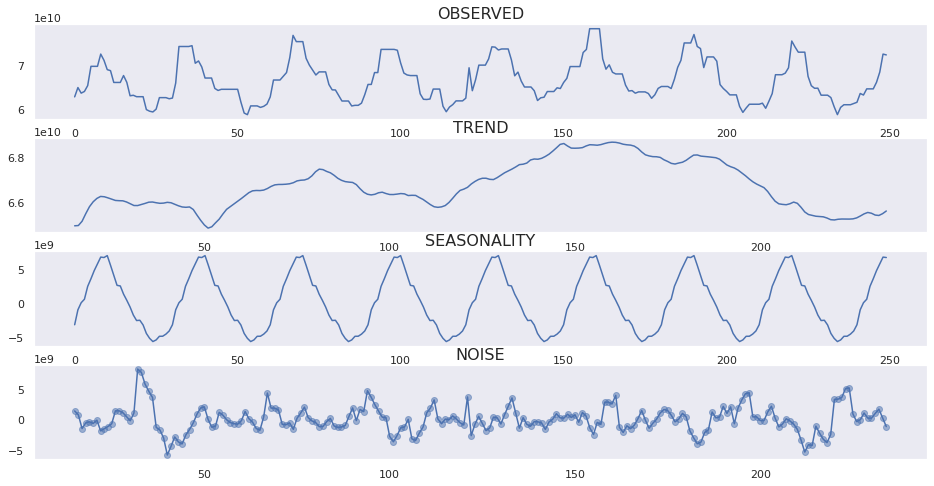

In [8]:
decompose_df(df)

In [9]:
from darts.timeseries import TimeSeries

# analyze its seasonality
ts = TimeSeries.from_dataframe(df.filter(['VALUE']))
is_seasonal, periodicity = check_seasonality(ts, max_lag=50)
dict_seas ={
    "is seasonal?":is_seasonal, 
    "periodicity (months)":f'{periodicity:.1f}', 
    "periodicity (~years)": f'{periodicity/12:.1f}'}
_ = [print(k,":",v) for k,v in dict_seas.items()]

is seasonal? : True
periodicity (months) : 28.0
periodicity (~years) : 2.3


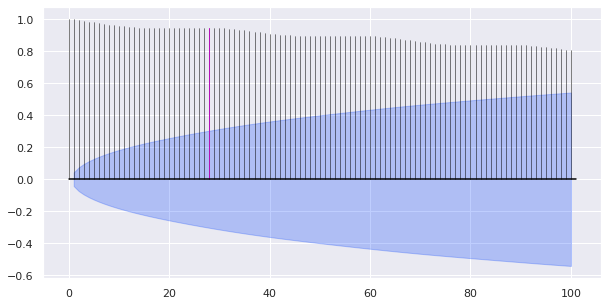

In [10]:
plot_acf(ts, periodicity, max_lag=100)

## Feature engineering

In [158]:
#create hour, day and month variables from datetime index
df['week'] = df.index.isocalendar().week 
df['weekday'] = df.index.weekday
df['day'] = df.index.day
df['month'] = df.index.month

In [159]:
def generate_time_lags(df, n_lags):
    df_n = df.copy()
    for n in range(1, n_lags + 1):
        df_n[f"lag{n}"] = df_n["VALUE"].shift(n)
    df_n = df_n.iloc[n_lags:]
    return df_n

df_with_time_lags = generate_time_lags(df, 14)
df_with_time_lags.head()

,VALUE,week,weekday,day,month,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10,lag11,lag12,lag13,lag14
REPORTDATE,,,,,,,,,,,,,,,,,,,
2014-01-13,3681610469,3,0,13,1,3.560465e+09,3.560465e+09,3.560465e+09,3.618829e+09,3.630284e+09,3.320847e+09,3.320847e+09,3.417092e+09,3.417092e+09,3.417092e+09,3.417092e+09,3.417092e+09,3.417092e+09,3.457626e+09
2014-01-14,3603764610,3,1,14,1,3.681610e+09,3.560465e+09,3.560465e+09,3.560465e+09,3.618829e+09,3.630284e+09,3.320847e+09,3.320847e+09,3.417092e+09,3.417092e+09,3.417092e+09,3.417092e+09,3.417092e+09,3.417092e+09
2014-01-15,3300717238,3,2,15,1,3.603765e+09,3.681610e+09,3.560465e+09,3.560465e+09,3.560465e+09,3.618829e+09,3.630284e+09,3.320847e+09,3.320847e+09,3.417092e+09,3.417092e+09,3.417092e+09,3.417092e+09,3.417092e+09
2014-01-16,3397894707,3,3,16,1,3.300717e+09,3.603765e+09,3.681610e+09,3.560465e+09,3.560465e+09,3.560465e+09,3.618829e+09,3.630284e+09,3.320847e+09,3.320847e+09,3.417092e+09,3.417092e+09,3.417092e+09,3.417092e+09
2014-01-17,3513671586,3,4,17,1,3.397895e+09,3.300717e+09,3.603765e+09,3.681610e+09,3.560465e+09,3.560465e+09,3.560465e+09,3.618829e+09,3.630284e+09,3.320847e+09,3.320847e+09,3.417092e+09,3.417092e+09,3.417092e+09


In [13]:
def generate_cyclical_features(df, col_name, period, start_num=0):
    kwargs = {
        f'sin_{col_name}' : lambda x: np.sin(2*np.pi*(df[col_name]-start_num)/period),
        f'cos_{col_name}' : lambda x: np.cos(2*np.pi*(df[col_name]-start_num)/period)    
             }
    return df.assign(**kwargs).drop(columns=[col_name])

# df_cyclical_features = generate_cyclical_features(df, 'weekday', 7, 0)
# df_cyclical_features = generate_cyclical_features(df, 'month', 12, 1)
df_cyclical_features = generate_cyclical_features(df, 'week', 52, 0)

df_cyclical_features = pd.concat([
    generate_cyclical_features(df, 'weekday', 7, 0).drop(['day', 'week', 'month'], axis=1),
    generate_cyclical_features(df, 'month', 12, 1).drop(['day', 'weekday', 'week', 'VALUE'], axis=1),
    generate_cyclical_features(df, 'week', 52, 0).drop(['day', 'month', 'weekday', 'VALUE'], axis=1)
], axis=1)

In [14]:
df_cyclical_features.head()

,VALUE,sin_weekday,cos_weekday,sin_month,cos_month,sin_week,cos_week
REPORTDATE,,,,,,,
2013-12-30,3457625638,0.000000,1.000000,-0.5,0.866025,0.120537,0.992709
2013-12-31,3417092149,0.781831,0.623490,-0.5,0.866025,0.120537,0.992709
2014-01-01,3417092149,0.974928,-0.222521,0.0,1.000000,0.120537,0.992709
2014-01-02,3417092149,0.433884,-0.900969,0.0,1.000000,0.120537,0.992709
2014-01-03,3417092149,-0.433884,-0.900969,0.0,1.000000,0.120537,0.992709


In [15]:
def onehot_encode_pd(df, col_name):
    for i in col_name:
        dummies = pd.get_dummies(df[i], prefix=i)
        df = pd.concat([df, dummies], axis=1).drop(columns=[i])
    return df

df_ohe_features = onehot_encode_pd(df, ['day', 'month', 'weekday','week'])
df_ohe_features.head()

,VALUE,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,...,week_44,week_45,week_46,week_47,week_48,week_49,week_50,week_51,week_52,week_53
REPORTDATE,,,,,,,,,,,,,,,,,,,,,
2013-12-30,3457625638,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2013-12-31,3417092149,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2014-01-01,3417092149,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2014-01-02,3417092149,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2014-01-03,3417092149,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [144]:
def code_mean(data, cat_feature, real_feature):
    """
    Возвращает словарь, где ключами являются уникальные категории признака cat_feature, 
    а значениями - средние по real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

def prepareData(data, lag_start=5, lag_end=13, test_size=0.15):

    data = pd.DataFrame(data.copy())
    data = data.set_index('REPORTDATE')
    data.columns = ["y"]

    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data) * (1 - test_size))

    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)
    
    # data.index = data.index.to_datetime()
    data["month"] = data.index.month
    data["weekday"] = data.index.weekday
    data["is_weekend"] = data.weekday.isin([5, 6]) * 1

    # считаем средние только по тренировочной части, чтобы избежать лика
    data["weekday_average"] = list(
        map(code_mean(data[:test_index], "weekday", "y").get, data.weekday)
    )
    data["month_average"] = list(
        map(code_mean(data[:test_index], "month", "y").get, data.month)
    )

    # выкидываем закодированные средними признаки
    data.drop(["month", "weekday"], axis=1, inplace=True)

    data = data.dropna()
    data = data.reset_index(drop=True)

    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["y"], axis=1)
    y_train = data.loc[:test_index]["y"]
    X_test = data.loc[test_index:].drop(["y"], axis=1)
    y_test = data.loc[test_index:]["y"]

    return X_train, X_test, y_train, y_test

In [145]:
data_lr = df.copy()
X_train, X_test, y_train, y_test = prepareData(
    data_lr, test_size=0.3
)

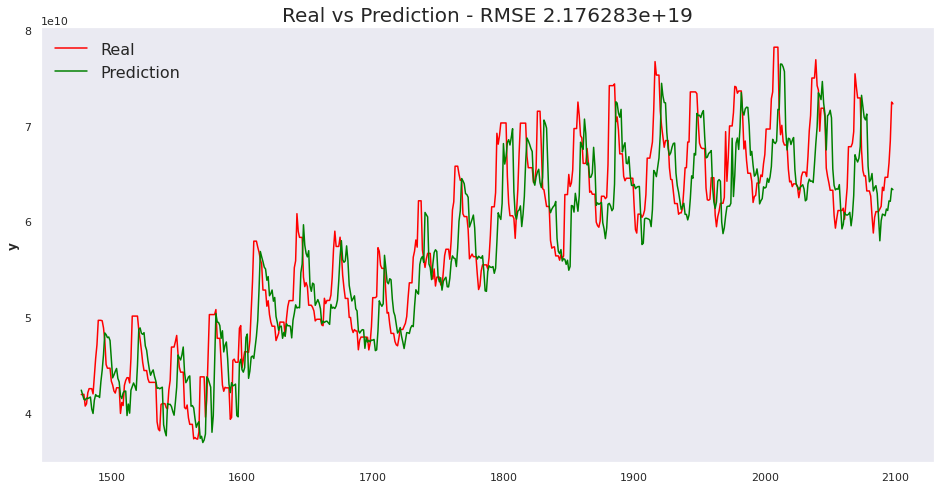

In [152]:
model = LinearRegression()
model.fit(X_train, y_train)
prediction = model.predict(X_test)
rmse = mean_squared_error(y_test, prediction)

plot_preds(rmse, prediction, y_test)

## Training models

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [75]:
def plot_preds(metric, predictions, y_test):
    metric = "{:e}".format(metric)
    fig = plt.figure(figsize=(16,8))
    plt.title(f'Real vs Prediction - RMSE {metric}', fontsize=20)
    sns.lineplot(data=y_test, color='red')
    sns.lineplot(data=pd.Series(predictions, index=y_test.index), color='green')
    plt.legend(labels=['Real', 'Prediction'], fontsize=16)
    plt.grid()
    plt.show()
    
def make_train_data(df):
    X = np.array(df.iloc[:, 1:])
    y = df.VALUE
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.85)
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.90)
    return X_train, X_test, X_valid, y_train, y_test, y_valid

def train(model, df, grid=None):
    X_train, X_test, X_valid, y_train, y_test, y_valid = make_train_data(df)
    
    if grid is not None:
        model = model.grid_search(grid, X=X_train, y=y_train, plot=True, verbose=False, refit=True)
        
    else:
        model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)],  plot=True, verbose=False, use_best_model=True)
        
    predictions = model.predict(X_test)
    rmse = np.round(mean_squared_error(y_test, predictions) ** 0.5, 3)
    plot_preds(rmse, predictions, y_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

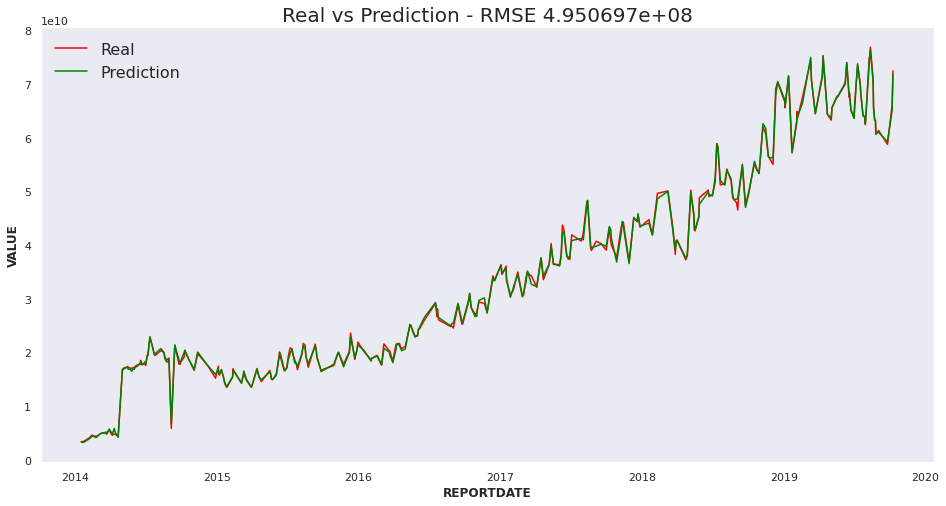

In [161]:
cb_reg = CatBoostRegressor(loss_function='RMSE', logging_level='Silent')
train(cb_reg, df_with_time_lags)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

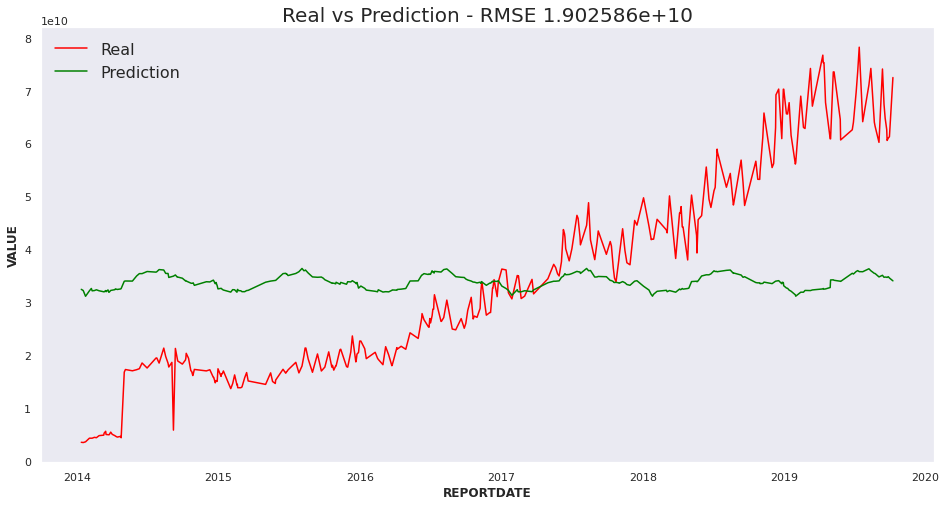

In [162]:
cb_reg = CatBoostRegressor(loss_function='RMSE', logging_level='Silent')
train(cb_reg, df_cyclical_features)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

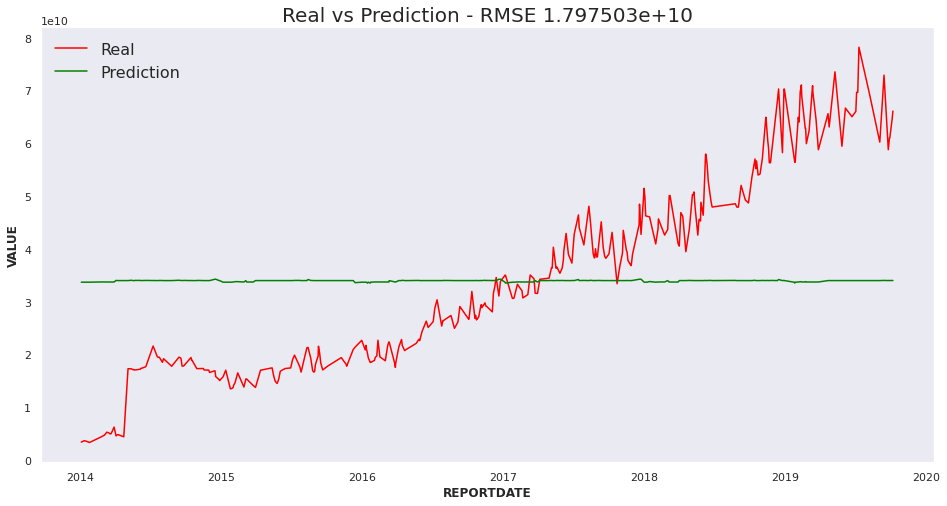

In [163]:
cb_reg = CatBoostRegressor(loss_function='RMSE', logging_level='Silent')
train(cb_reg, df_ohe_features)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

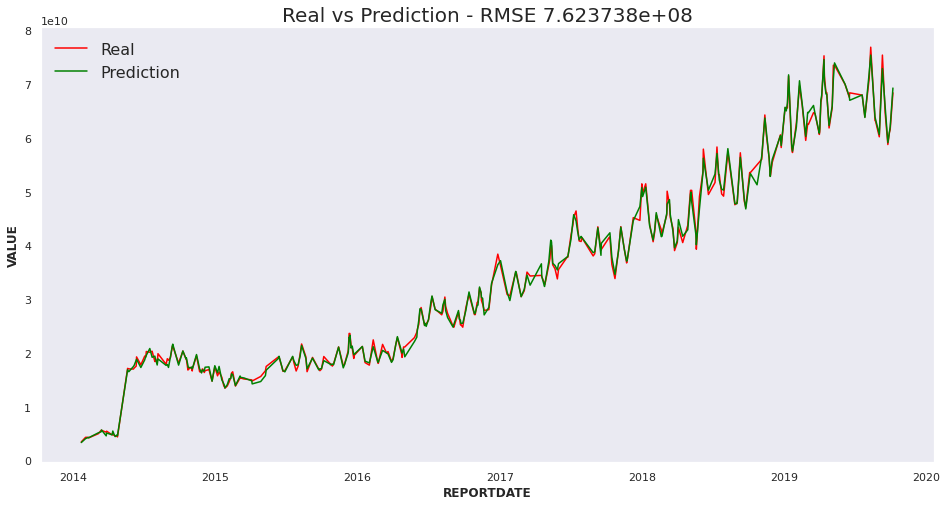

In [164]:
cb_reg = CatBoostRegressor(loss_function='RMSE', logging_level='Silent')
train(cb_reg, df_shift)

In [ ]:
grid = {
        'depth': [4, 6, 10],
        'learning_rate' : [0.01, 0.05, 0.1],
        'iterations': [100, 150, 200, 1000],
        'l2_leaf_reg': [1, 3, 5, 7, 9]
}

cb_reg = CatBoostRegressor(loss_function='RMSE', logging_level='Silent')
train(cb_reg, df_with_time_lags, grid=grid)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

## Training RNN

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler

def get_scaler(scaler):
    scalers = {
        "minmax": MinMaxScaler,
        "standard": StandardScaler,
        "maxabs": MaxAbsScaler,
        "robust": RobustScaler,
    }
    return scalers.get(scaler.lower())()
    
scaler = get_scaler('robust')

In [ ]:
make_train_dataain, X_test, X_valid, y_train, y_test, y_valid = make_train_data(df_with_time_lags)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 64

train_features = torch.Tensor(X_train_arr)
train_targets = torch.Tensor(y_train_arr)
val_features = torch.Tensor(X_val_arr)
val_targets = torch.Tensor(y_val_arr)
test_features = torch.Tensor(X_test_arr)
test_targets = torch.Tensor(y_test_arr)

train = TensorDataset(train_features, train_targets)
val = TensorDataset(val_features, val_targets)
test = TensorDataset(test_features, test_targets)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader_one = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)

,VALUE,day,month,day_of_week,week_of_year,sin_day_of_week,cos_day_of_week,sin_month,cos_month,sin_week_of_year,cos_week_of_year
REPORTDATE,,,,,,,,,,,
2013-12-30,3457625638,30,12,0,1,0.000000,1.000000,-0.5,8.660254e-01,0.120537,0.992709
2013-12-31,3417092149,31,12,1,1,0.781831,0.623490,-0.5,8.660254e-01,0.120537,0.992709
2014-01-01,3417092149,1,1,2,1,0.974928,-0.222521,0.0,1.000000e+00,0.120537,0.992709
2014-01-02,3417092149,2,1,3,1,0.433884,-0.900969,0.0,1.000000e+00,0.120537,0.992709
2014-01-03,3417092149,3,1,4,1,-0.433884,-0.900969,0.0,1.000000e+00,0.120537,0.992709
...,...,...,...,...,...,...,...,...,...,...,...
2019-10-06,64630140507,6,10,6,40,-0.781831,0.623490,-1.0,-1.836970e-16,-0.992709,0.120537
2019-10-07,66115288637,7,10,0,41,0.000000,1.000000,-1.0,-1.836970e-16,-0.970942,0.239316
2019-10-08,68424049766,8,10,1,41,0.781831,0.623490,-1.0,-1.836970e-16,-0.970942,0.239316


In [158]:
df_features

,VALUE,sin_day_of_week,cos_day_of_week,sin_month,cos_month,sin_week_of_year,cos_week_of_year,day_1,day_2,day_3,...,week_of_year_44,week_of_year_45,week_of_year_46,week_of_year_47,week_of_year_48,week_of_year_49,week_of_year_50,week_of_year_51,week_of_year_52,week_of_year_53
REPORTDATE,,,,,,,,,,,,,,,,,,,,,
2013-12-30,3457625638,0.000000,1.000000,-0.5,8.660254e-01,0.120537,0.992709,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2013-12-31,3417092149,0.781831,0.623490,-0.5,8.660254e-01,0.120537,0.992709,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2014-01-01,3417092149,0.974928,-0.222521,0.0,1.000000e+00,0.120537,0.992709,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2014-01-02,3417092149,0.433884,-0.900969,0.0,1.000000e+00,0.120537,0.992709,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2014-01-03,3417092149,-0.433884,-0.900969,0.0,1.000000e+00,0.120537,0.992709,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-06,64630140507,-0.781831,0.623490,-1.0,-1.836970e-16,-0.992709,0.120537,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-10-07,66115288637,0.000000,1.000000,-1.0,-1.836970e-16,-0.970942,0.239316,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-10-08,68424049766,0.781831,0.623490,-1.0,-1.836970e-16,-0.970942,0.239316,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [82]:
class LSTM(nn.Module):
    
    def __init__(self,input_size = 1, hidden_size = 50, out_size = 1):
        super().__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.linear = nn.Linear(hidden_size,out_size)
        self.hidden = (torch.zeros(1,1,hidden_size),torch.zeros(1,1,hidden_size))
    
    def forward(self,seq):
        lstm_out, self.hidden = self.lstm(seq.view(len(seq),1,-1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq),-1))
        return pred[-1]

In [83]:
torch.manual_seed(42)
model = LSTM()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())